Alzheimer's is a type of dementia that affects a person's Memory, Thought and Behavior. It is a disease that begins mildly and affects parts of the brain, which makes the person have difficulty, to remember newly learned information, constant changes in mood, and confusion with events, times and places.
 
Alzheimer's usually starts after age 60. The risk increases as the person ages. The risk of having this disease is greater if there are people in the family who have had this disease.
 
As for the treatments that have been done for this disease, there is none that can stop the progress of this. So far what these treatments can achieve is to help alleviate some symptoms, reducing their intensity and contributing to a higher quality of life for patients and their families.

<img src="https://gx0ri2vwi9eyht1e3iyzyc17-wpengine.netdna-ssl.com/wp-content/uploads/2017/01/dementia2-804x369.jpg" alt="AzBoruta" border="0">

## objective

Implement classification algorithms for the analysis of the medical dataset, in order to provide a prediction tool for the early diagnosis of the disease.

V2 Predict CDR : https://www.kaggle.com/rodrigox93/multi-class-model-detect-cdr-acc-83-f1-78

# Table of Contents

* **1. [ Declaration of functions](#ch1)**
* ** 2 [ Analysis of data](#ch2)**
     * 2.1 [Read dataset](#ch3) 
     * 2.2 [Correlation Analysis](#ch4) 
     * 2.3 [Correlation matrix](#ch5) 
     * 2.4 [Dispersion matrix](#ch6) 
     * 2.5 [Graphs of all these correlations](#ch7) 
     * 2.6 [Miscellaneous Graphics](#ch8) 
* ** 3 [Preprocessing](#ch9)**
     * 3.1 [Remove Useless Columns](#ch10)
     * 3.2 [LabelEncoder](#ch11)
     * 3.3 [Imputation of lost values](#ch12)
     * 3.4 [Standardization](#ch13)
     * 3.5 [Export them to then select the features](#ch14)
* **  4 [Modeling](#ch15)** 
     * 4.1 [Tuning Hyperparameters for better models](#ch15)
     * 4.2 [Generating our models](#ch16)
     * 4.3 [Cross Validation](#ch17)
* **  5. [Importance of characteristics](#ch18)**
* **  6. [Predictions](#ch19)**
* ** 7. [Performance Metric for each model](#ch21)**
    * 7.1 [Report ](#ch22)
    * 7.2 [Results ](#ch23)

## Required libraries

In [3]:
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


FOLDS =10
%matplotlib inline

<a id="ch1"></a>
# 1. Declaration of functions

## Graphing functions 

In [4]:
# Function to graph number of people by age
def cont_age(field):
    plt.figure()
    g = None
    if field == "Age":
        df_query_mri = df[df["Age"] > 0]
        g = sns.countplot(df_query_mri["Age"])
        g.figure.set_size_inches(18.5, 10.5)
    else:
        g = sns.countplot(df[field])
        g.figure.set_size_inches(18.5, 10.5)
    
sns.despine()

<Figure size 432x288 with 0 Axes>

In [5]:
# Function to graph number of people per state [Demented, Nondemented]
def cont_Dementes(field):
    plt.figure()
    g = None
    if field == "Group":
        df_query_mri = df[df["Group"] >= 0]
        g = sns.countplot(df_query_mri["Group"])
        g.figure.set_size_inches(18.5, 10.5)
    else:
        g = sns.countplot(df[field])
        g.figure.set_size_inches(18.5, 10.5)
    
sns.despine()

<Figure size 432x288 with 0 Axes>

In [6]:
# 0 = F y 1= M
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))

In [7]:
def report_performance(model):

    model_test = model.predict(X_test)

    print("Confusion Matrix")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("")
    print("Classification Report")
    print(metrics.classification_report(y_test, model_test))

<a id="ch2"></a>
 # 2. Analysis of data

<a id="ch3"></a>
## 2.1 read dataset

In [9]:
data = 'oasis_longitudinal.csv'
df = pd.read_csv (data)
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [10]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [11]:
nu = pd.DataFrame(df['Group']=='Nondemented')
nu["Group"].value_counts() 

True     190
False    183
Name: Group, dtype: int64

<a id="ch4"></a>
## 2.2 Correlation Analysis

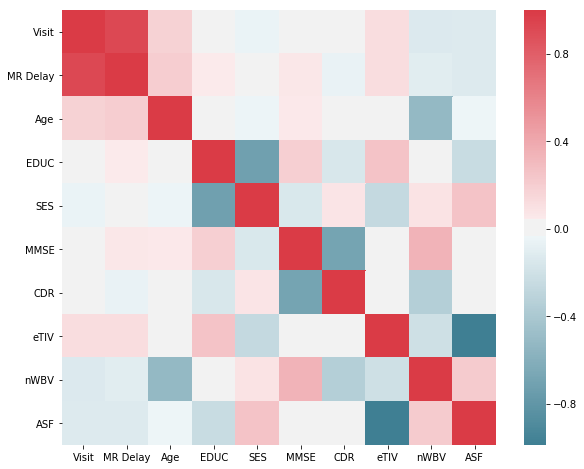

In [12]:
f, ax = plt.subplots(figsize=(10, 8)) 
corr = df.corr(method = 'pearson') 
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, ax=ax) 

<a id="ch5"></a>
## 2.3 Correlation matrix

In [13]:
df.corr(method = 'pearson') 

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
Visit,1.000000,0.920009,0.183213,0.024615,-0.051622,-0.029078,0.002325,0.117428,-0.126682,-0.120399
MR Delay,0.920009,1.000000,0.205357,0.051630,-0.030813,0.065844,-0.062915,0.119624,-0.105586,-0.123545
Age,0.183213,0.205357,1.000000,-0.027886,-0.046857,0.055612,-0.026257,0.042348,-0.518359,-0.035067
EDUC,0.024615,0.051630,-0.027886,1.000000,-0.722647,0.194884,-0.153121,0.257015,-0.012200,-0.241752
SES,-0.051622,-0.030813,-0.046857,-0.722647,1.000000,-0.149219,0.076160,-0.261575,0.090095,0.255576
MMSE,-0.029078,0.065844,0.055612,0.194884,-0.149219,1.000000,-0.686519,-0.032084,0.341912,0.040052
CDR,0.002325,-0.062915,-0.026257,-0.153121,0.076160,-0.686519,1.000000,0.022819,-0.344819,-0.029340
eTIV,0.117428,0.119624,0.042348,0.257015,-0.261575,-0.032084,0.022819,1.000000,-0.210122,-0.988877
nWBV,-0.126682,-0.105586,-0.518359,-0.012200,0.090095,0.341912,-0.344819,-0.210122,1.000000,0.213476
ASF,-0.120399,-0.123545,-0.035067,-0.241752,0.255576,0.040052,-0.029340,-0.988877,0.213476,1.000000


<a id="ch6"></a>
## 2.4 Dispersion matrix

C:\Users\pradhyumna\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead



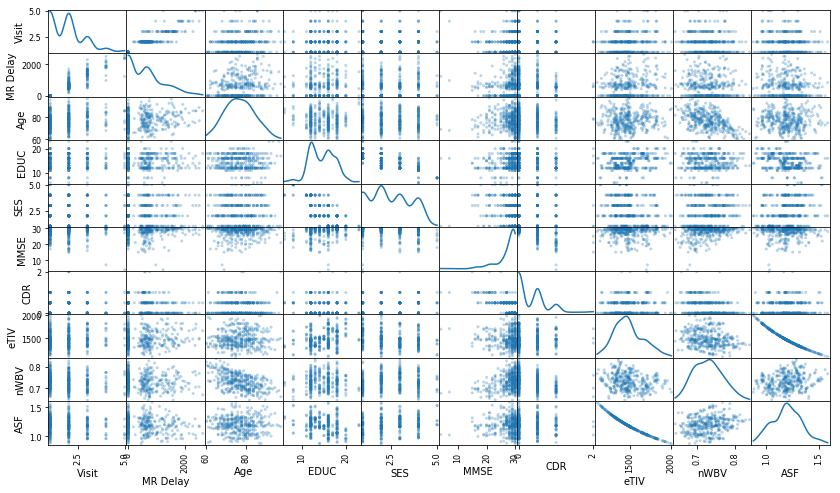

In [14]:
pd.scatter_matrix(df, alpha = 0.3, figsize = (14,8), diagonal = 'kde'); 

<a id="ch7"></a>
## 2.5 Graphs of all these correlations

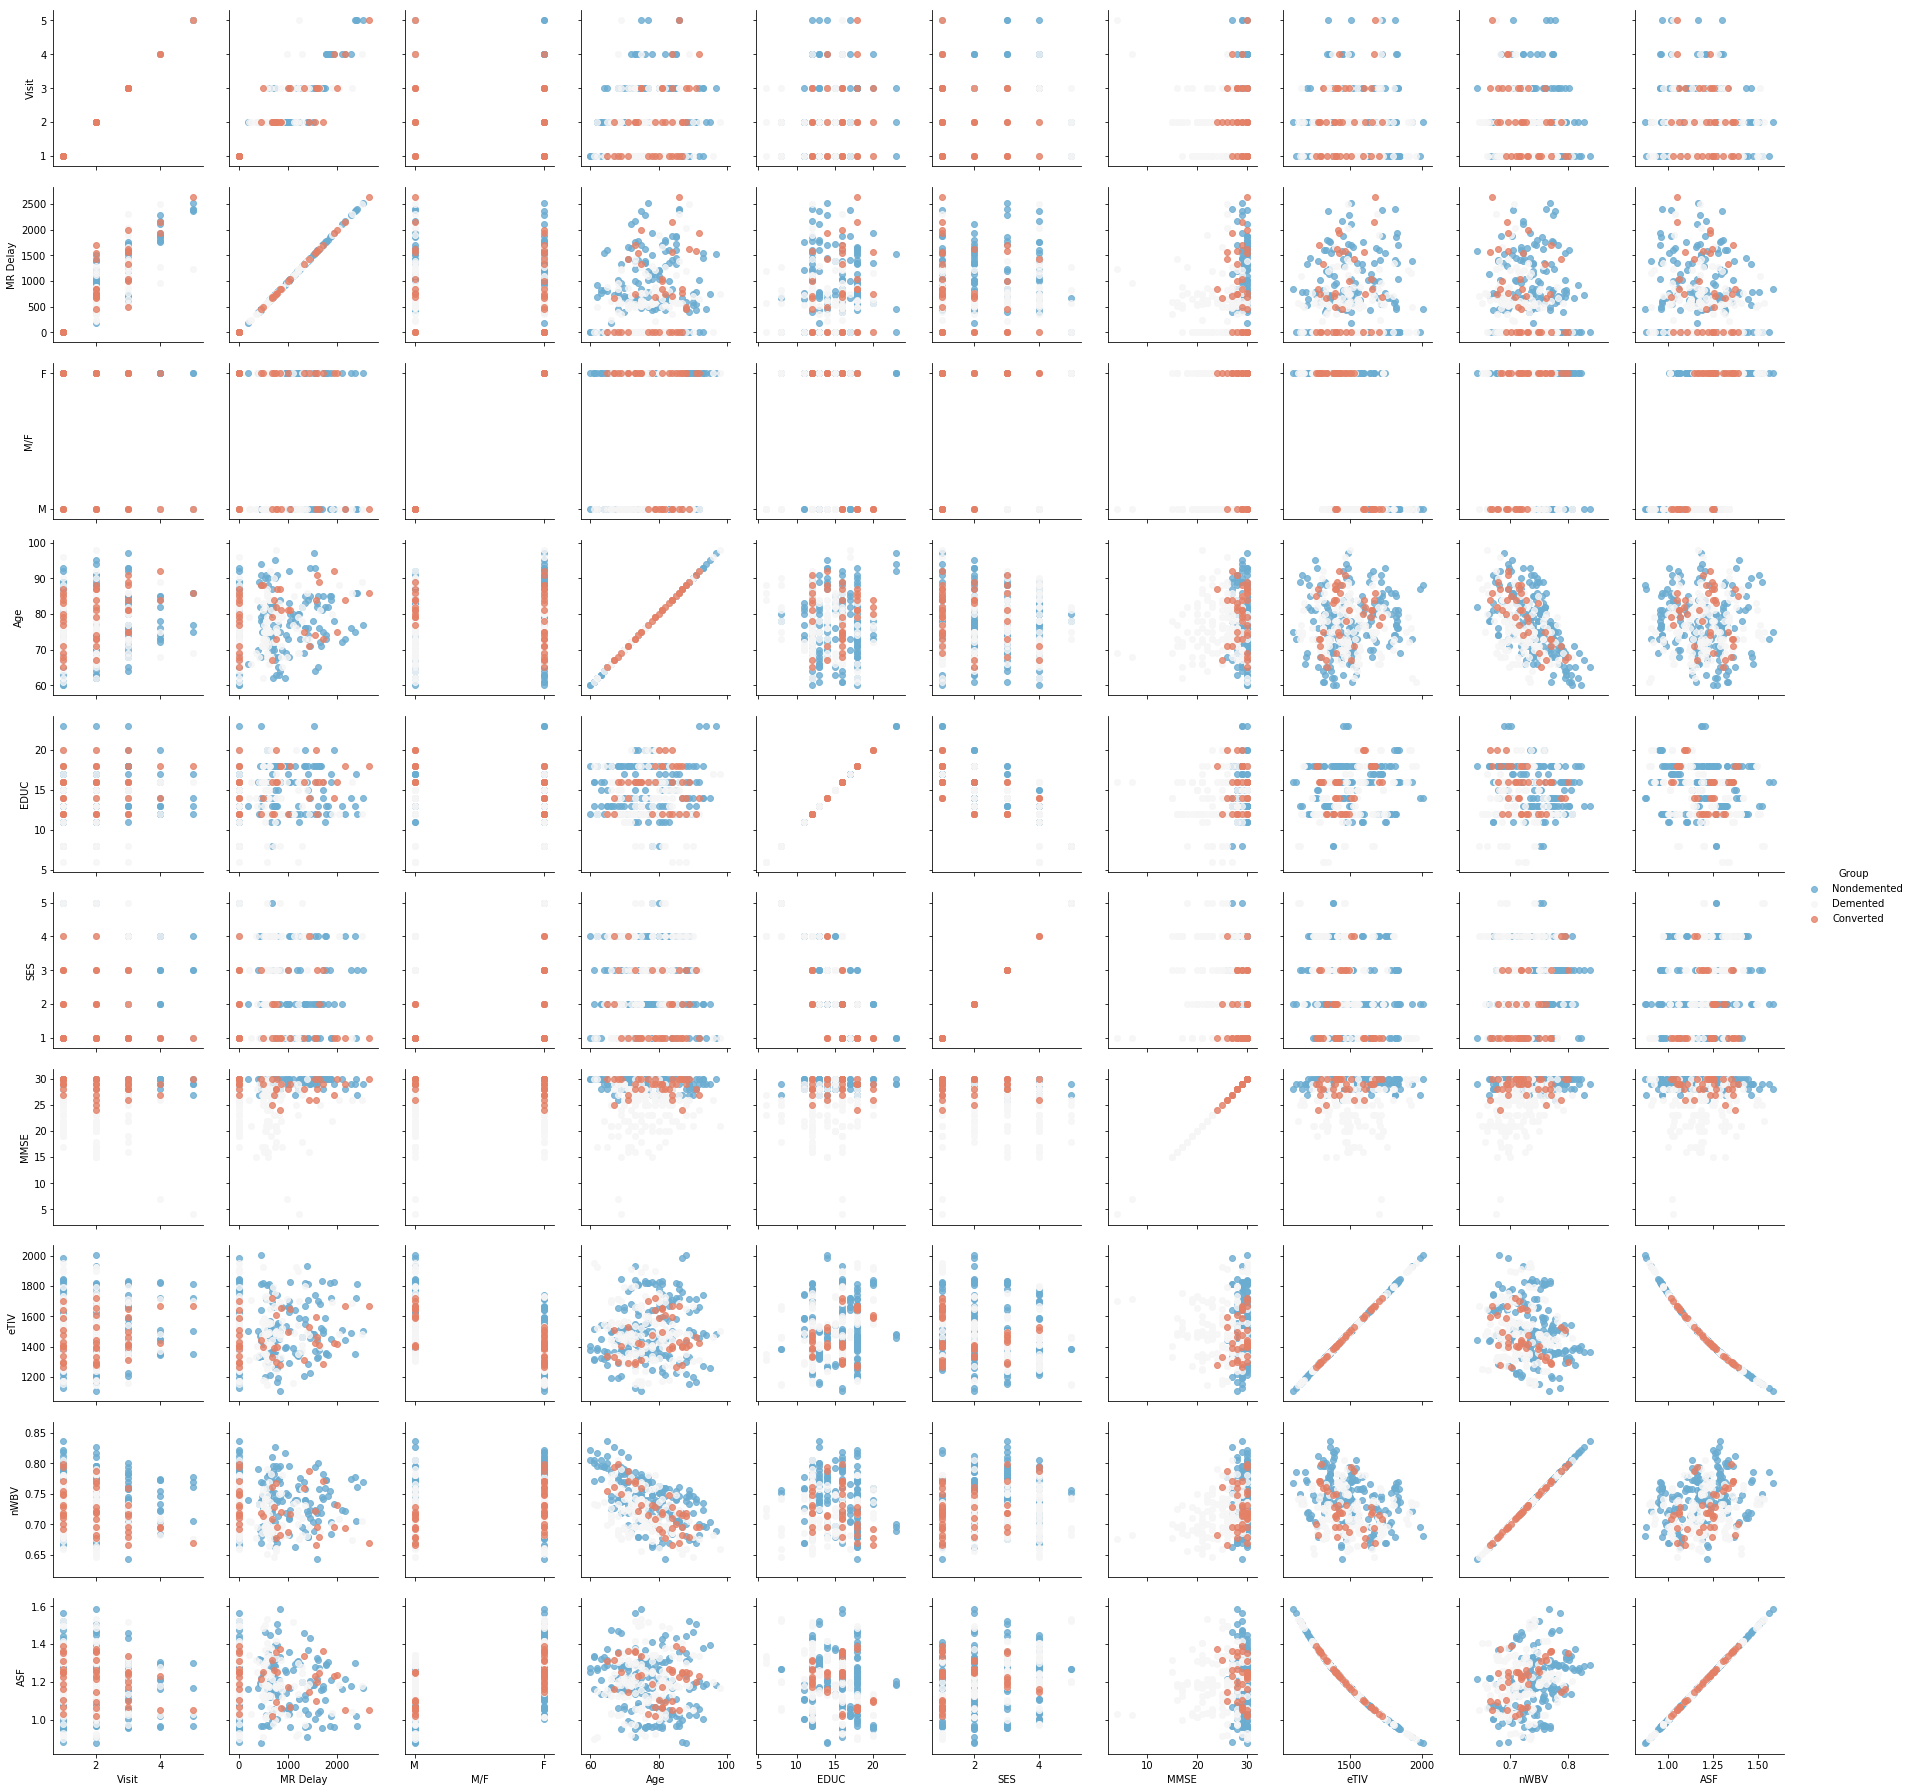

In [15]:
g = sns.PairGrid(df, vars=['Visit','MR Delay','M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF'],
                 hue='Group', palette='RdBu_r')
g.map(plt.scatter, alpha=0.8)
g.add_legend();

<a id="ch8"></a>
## 2.6 Miscellaneous Graphics

**Number of Demented, Nondemented and Converted depending on the sex of the patient**

C:\Users\pradhyumna\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



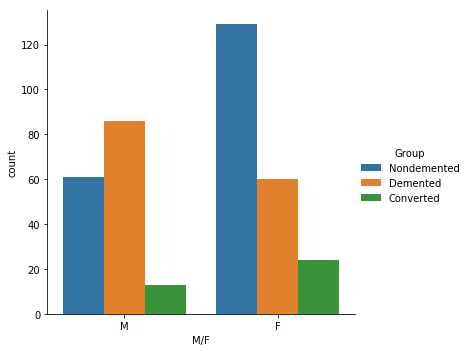

In [16]:
import seaborn as sb
sb.factorplot('M/F',data=df,hue='Group',kind="count")

**Variation of the dementia according to the MMSE depending on the scores of each patient**

C:\Users\pradhyumna\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



(12.5, 30.0)

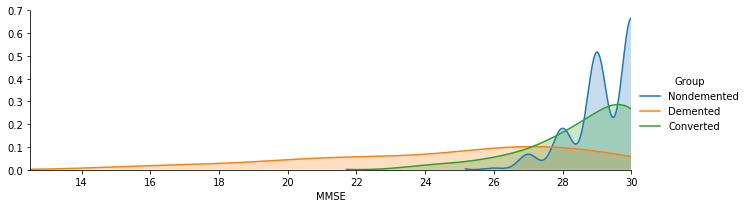

In [17]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',shade= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(12.5)

**Number of patients of each age**

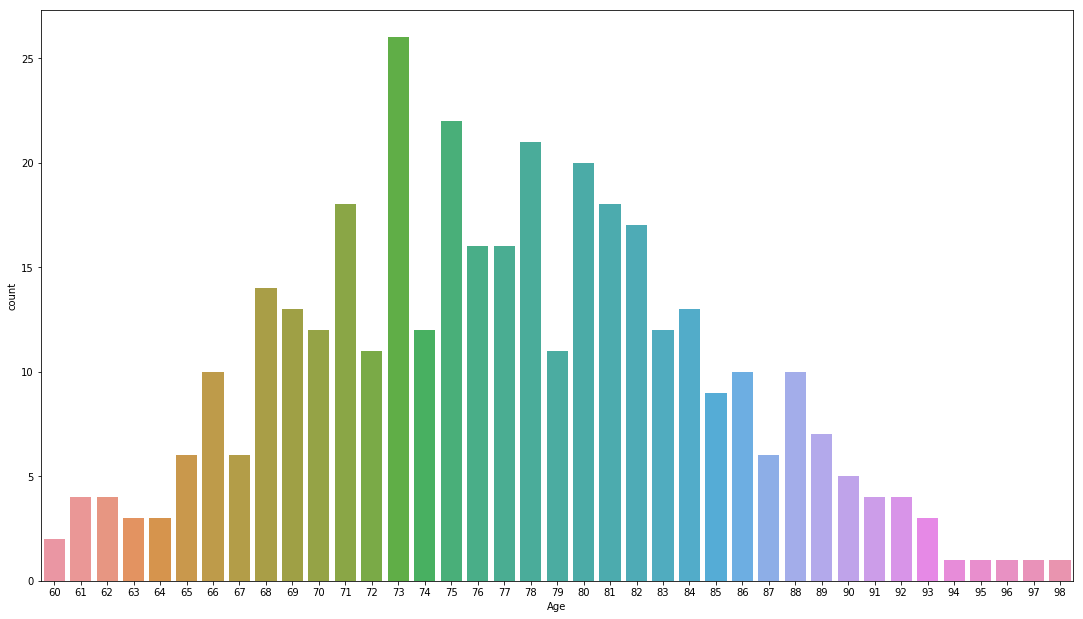

In [18]:
cont_age("Age")

 <a id="ch9"></a>
# 3. Preprocessing

**Replace data Convert a Dement**

In [19]:
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])
df.head(3)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046


 <a id="ch10"></a>
## 3.1 Remove Useless Columns

In [20]:
df.drop(['Subject ID'], axis = 1, inplace = True, errors = 'ignore')
df.drop(['MRI ID'], axis = 1, inplace = True, errors = 'ignore')
df.drop(['Visit'], axis = 1, inplace = True, errors = 'ignore')
#for this study the CDR we eliminated it
df.drop(['CDR'], axis = 1, inplace = True, errors = 'ignore')
df.head(3)

,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,Nondemented,0,M,R,87,14,2.0,27.0,1987,0.696,0.883
1,Nondemented,457,M,R,88,14,2.0,30.0,2004,0.681,0.876
2,Demented,0,M,R,75,12,NaN,23.0,1678,0.736,1.046


 <a id="ch11"></a>
## 3.2 LabelEncoder

****We are going to use Binarized LabelEncoder for our Binary attributes********

**Which are sex and our class**

In [21]:
# 1 = Demented, 0 = Nondemented
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])

df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0])    
df.head(3)

,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,0,M,R,87,14,2.0,27.0,1987,0.696,0.883
1,0,457,M,R,88,14,2.0,30.0,2004,0.681,0.876
2,1,0,M,R,75,12,NaN,23.0,1678,0.736,1.046


In [22]:
# 1= M, 0 = F

df['M/F'] = df['M/F'].replace(['M', 'F'], [1,0])  
df.head(3)

,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,0,1,R,87,14,2.0,27.0,1987,0.696,0.883
1,0,457,1,R,88,14,2.0,30.0,2004,0.681,0.876
2,1,0,1,R,75,12,NaN,23.0,1678,0.736,1.046


In [23]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
encoder.fit(df.Hand.values)
list(encoder.classes_)
#Transoformamos
encoder.transform(df.Hand.values)
df[['Hand']]=encoder.transform(df.Hand.values)
encoder2=LabelEncoder()
encoder2.fit(df.Hand.values)
list(encoder2.classes_)

[0]

 <a id="ch12"></a>
## 3.3 Imputation of lost values

For various reasons, many real-world data sets contain missing values, often encoded as blanks, NaNs, or other placeholders. However, these data sets are incompatible with scikit-learn estimators that assume that all values ​​in a matrix are numeric, and that they all have and have meaning. A basic strategy for using incomplete datasets is to discard rows and / or complete columns that contain missing values. However, this has the price of losing data that can be valuable (though incomplete). A better strategy is to impute the lost values, that is, to deduce them from the known part of the data.

The Imputer class provides basic strategies for imputation of missing values, using either the mean, the median or the most frequent value of the row or column in which the missing values ​​are found. This class also allows different encodings of missing values.

**Lost data**

In [24]:
data_na = (df.isnull().sum() / len(df)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Lost proportion (%)' :round(data_na,2)})
missing_data.head(20)

,Lost proportion (%)
SES,5.09
MMSE,0.54


In [25]:
from sklearn.impute  import SimpleImputer
# We perform it with the most frequent value 
imputer = SimpleImputer ( missing_values = np.nan,strategy='most_frequent')

imputer.fit(df[['SES']])
df[['SES']] = imputer.fit_transform(df[['SES']])

# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(df[['MMSE']])
df[['MMSE']] = imputer.fit_transform(df[['MMSE']])

In [26]:
from sklearn.impute  import SimpleImputer
# We perform it with the median
imputer = SimpleImputer ( missing_values = np.nan,strategy='median')

imputer.fit(df[['MMSE']])
df[['MMSE']] = imputer.fit_transform(df[['MMSE']])

 <a id="ch13"></a>
# 3.4 Standardization

In [27]:
from sklearn.preprocessing import StandardScaler
df_norm = df
scaler = StandardScaler()
df_norm[['Age','MR Delay','M/F','Hand','EDUC','SES','MMSE','eTIV','nWBV','ASF']]=scaler.fit_transform(df[['Age','MR Delay','M/F','Hand','EDUC','SES','MMSE','eTIV','nWBV','ASF']])

In [28]:
df_norm.head(3)

,Group,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,-0.937715,1.153798,0.0,1.308738,-0.208132,-0.394466,-0.095686,2.836059,-0.905169,-2.265742
1,0,-0.217613,1.153798,0.0,1.439787,-0.208132,-0.394466,0.721664,2.932703,-1.309643,-2.316501
2,1,-0.937715,1.153798,0.0,-0.263856,-0.904394,-0.394466,-1.185486,1.079409,0.173429,-1.083784


 <a id="ch14"></a>
## 3.5 Export them to then select the features

df_norm.to_csv('DatasetSelectionAttributes.csv', sep=',',index=False)

For the selection of attributes we use the R Boruta framework.

**Commands (R) :**

library(readr)

library(Boruta)

covertype <- read_csv('DatasetSelectionAttributes.csv')

set.seed(111)

boruta.trainer <- Boruta(Group~., data = covertype , doTrace = 2, maxRuns=500)

print(boruta.trainer)

plot(boruta.trainer, las = 2)


## Result:

<a href="https://ibb.co/QMGP76c"><img src="https://i.ibb.co/cQd6KNv/AzBoruta.png" alt="AzBoruta" border="0"></a>

## Remove Columns selected by boruta

In [29]:
df.drop(['Hand'], axis = 1, inplace = True, errors = 'ignore')
df.drop(['MR Delay'], axis = 1, inplace = True, errors = 'ignore')

In [30]:
df.head()

,Group,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,0,1.153798,1.308738,-0.208132,-0.394466,-0.095686,2.836059,-0.905169,-2.265742
1,0,1.153798,1.439787,-0.208132,-0.394466,0.721664,2.932703,-1.309643,-2.316501
2,1,1.153798,-0.263856,-0.904394,-0.394466,-1.185486,1.079409,0.173429,-1.083784
3,1,1.153798,-0.132806,-0.904394,-0.394466,0.176764,1.420506,-0.446765,-1.344830
4,1,1.153798,0.391392,-0.904394,-0.394466,-1.457936,1.193108,-0.770344,-1.170800


 <a id="ch15"></a>
# 4 Modeling

In [31]:
data_test = df

In [32]:
X = data_test.drop(["Group"],axis=1)
y = data_test["Group"].values
X.head(3)

,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,1.153798,1.308738,-0.208132,-0.394466,-0.095686,2.836059,-0.905169,-2.265742
1,1.153798,1.439787,-0.208132,-0.394466,0.721664,2.932703,-1.309643,-2.316501
2,1.153798,-0.263856,-0.904394,-0.394466,-1.185486,1.079409,0.173429,-1.083784


In [33]:
# We divide our data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 0)

In [34]:
print("{0:0.2f}% Train".format((len(X_train)/len(data_test.index)) * 100))
print("{0:0.2f}% Test".format((len(X_test)/len(data_test.index)) * 100))

74.80% Train
25.20% Test


In [35]:
print("Original Demented : {0} ({1:0.2f}%)".format(len(df_norm.loc[df_norm['Group'] == 1]), 100 * (len(df_norm.loc[df_norm['Group'] == 1]) / len(df_norm))))
print("Original Nondemented : {0} ({1:0.2f}%)".format(len(df_norm.loc[df_norm['Group'] == 0]), 100 * (len(df_norm.loc[df_norm['Group'] == 0]) / len(df_norm))))
print("")
print("Training Demented : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 1]), 100 * (len(y_train[y_train[:] == 1]) / len(y_train))))
print("Training Nondemented : {0} ({1:0.2f}%)".format(len(y_train[y_train[:] == 0]), 100 * (len(y_train[y_train[:] == 0]) / len(y_train))))
print("")
print("Test Demented : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 1]), 100 * (len(y_test[y_test[:] == 1]) / len(y_test))))
print("Test Nondemented : {0} ({1:0.2f}%)".format(len(y_test[y_test[:] == 0]), 100 * (len(y_test[y_test[:] == 0]) / len(y_test))))

Original Demented : 183 (49.06%)
Original Nondemented : 190 (50.94%)

Training Demented : 139 (49.82%)
Training Nondemented : 140 (50.18%)

Test Demented : 44 (46.81%)
Test Nondemented : 50 (53.19%)


 <a id="ch16"></a>
## 4.1 Tuning Hyperparameters for better models

Before adjusting our models, we will look for the parameters that give us a high AUC

**1°  Random Forest**

In [36]:
# Number of trees in random forest
n_estimators = range(10,250)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = range(1,40)
# Minimum number of samples required to split a node
min_samples_split = range(3,60)

In [37]:
# Create the random grid
parametro_rf = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [38]:
model_forest = RandomForestClassifier(n_jobs=-1)
forest_random = RandomizedSearchCV(estimator = model_forest, param_distributions = parametro_rf, n_iter = 100, cv = FOLDS, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='neg_mean_absolute_error')
forest_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished
C:\Users\pradhyumna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=-1,

In [39]:
forest_random.best_params_

{'n_estimators': 211,
 'min_samples_split': 5,
 'max_features': 'sqrt',
 'max_depth': 26}

In [40]:
model_rf = forest_random.best_estimator_
model_rf =  RandomForestClassifier(n_estimators=60,min_samples_split=8,max_features='sqrt',max_depth= 37)
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=37, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=60,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [41]:
test_score = cross_val_score(model_rf, X_train, y_train, cv=FOLDS, scoring='roc_auc').mean()
test_score

0.9114207221350078

In [42]:
test_score = cross_val_score(model_rf, X_train, y_train, cv=FOLDS, scoring='accuracy').mean()
test_score

0.8063492063492064

In [43]:
Predicted_rf= model_rf.predict(X_test)
test_recall = recall_score(y_test, Predicted_rf, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_rf, pos_label=1)
test_auc = auc(fpr, tpr)

**** 2° Extra Tree****

In [44]:
# Number of trees in random forest
n_estimators = range(50,280)
# Maximum number of levels in tree
max_depth =  range(1,40)
# Minimum number of samples required to split a node
min_samples_leaf = [3,4,5,6,7,8,9,10,15,20,30,40,50,60]

In [45]:
# Create the random grid
parametro_Et = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf}

In [46]:
model_et = ExtraTreesClassifier(n_jobs=-1)
et_random = RandomizedSearchCV(estimator = model_et, param_distributions = parametro_rf, n_iter = 100, cv = FOLDS, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
et_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.7min finished
C:\Users\pradhyumna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=ExtraTreesClassifier(bootstrap=False,
                                                  class_weight=None,
                                                  criterion='gini',
                                                  max_depth=None,
                                                  max_features='auto',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators='warn',
                                                  n_jobs=-1, oob_score=False,
       

In [47]:
et_random.best_params_

{'n_estimators': 46,
 'min_samples_split': 3,
 'max_features': 'sqrt',
 'max_depth': 20}

**3° AdaBoos**

In [48]:
n_estimators = range(10,200)

learning_rate = [0.0001, 0.001, 0.01, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,1]

In [49]:
# Create the random grid
parametros_ada = {'n_estimators': n_estimators,
               'learning_rate': learning_rate}

In [50]:
model_ada = AdaBoostClassifier()

ada_random = RandomizedSearchCV(estimator = model_ada, param_distributions = parametros_ada, n_iter = 100, cv = FOLDS, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
ada_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 486 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:  1.1min remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.1min finished
C:\Users\pradhyumna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=None,
                                                learning_rate=1.0,
                                                n_estimators=50,
                                                random_state=None),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 0.95, 1],
                                        'n_estimators': range(10, 200)},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=2)

In [51]:
ada_random.best_params_

{'n_estimators': 110, 'learning_rate': 0.6}

** 4° Gradient Boosting**

In [52]:
parametros_gb = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.005,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_split": [0.01, 0.025, 0.005,0.4,0.5, 0.075, 0.1, 0.15, 0.2,0.3,0.8,0.9],
    "min_samples_leaf": [1,2,3,5,8,10,15,20,40,50,55,60,65,70,80,85,90,100],
    "max_depth":[3,5,8,10,15,20,25,30,40,50],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":range(1,100)
    }

In [53]:
model_gb= GradientBoostingClassifier()


gb_random = RandomizedSearchCV(estimator = model_gb, param_distributions = parametros_gb, n_iter = 100, cv = FOLDS, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
gb_random.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 627 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 993 out of 1000 | elapsed:   24.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.0s finished
C:\Users\pradhyumna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                    

In [54]:
gb_random.best_params_

{'subsample': 1.0,
 'n_estimators': 30,
 'min_samples_split': 0.025,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 8,
 'loss': 'deviance',
 'learning_rate': 0.005,
 'criterion': 'mae'}

**5° Support Vector**

In [55]:
C = [0.001, 0.10, 0.1, 10, 25, 50,65,70,80,90, 100, 1000,2000,10000,20000,25000,30000,40000]

kernel =  ['rbf']
    
gamma =[1e-2, 1e-3, 1e-4, 1e-5,1e-6,1e-7,1e-8,1]

In [56]:
# Create the random grid
parametros_svm = {'C': C,
            'gamma': gamma,
             'kernel': kernel}

In [57]:
model_svm = SVC()
from sklearn.model_selection import GridSearchCV
svm_random = GridSearchCV(model_svm, parametros_svm,  cv = 20, 
                               verbose=2, n_jobs = -1, scoring='roc_auc')
svm_random.fit(X, y)

Fitting 20 folds for each of 144 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 1712 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:   25.6s finished
C:\Users\pradhyumna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



GridSearchCV(cv=20, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.001, 0.1, 0.1, 10, 25, 50, 65, 70, 80, 90, 100,
                               1000, 2000, 10000, 20000, 25000, 30000, 40000],
                         'gamma': [0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07,
                                   1e-08, 1],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=2)

**6° xgboost **

In [58]:
param_xgb = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [50,100,120]}

In [59]:
from sklearn.model_selection import GridSearchCV

model_xgb = xgb.XGBClassifier()
xgb_random = RandomizedSearchCV(estimator = model_xgb, param_distributions = param_xgb, n_iter = 100, cv = FOLDS, 
                               verbose=2, random_state=42, n_jobs = -1, scoring='roc_auc')
xgb_random.fit(X_train.values, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   25.2s finished
C:\Users\pradhyumna\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=...
                                        'gamma': [0, 0.25, 0.5, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.1, 0.2,
                                                          0, 3],
      

In [60]:
xgb_random.best_params_

{'subsample': 0.9,
 'silent': False,
 'reg_lambda': 0.1,
 'n_estimators': 120,
 'min_child_weight': 1.0,
 'max_depth': 6,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 0.4,
 'colsample_bylevel': 0.7}

# Selected Parameters

After running RandomizedSearchCV several times, we found the most acceptable parameters for each of our models.
We will save these parameters to then make the adjustment of our models.

In [61]:
parametro_rf = forest_random.best_params_

parametro_et = et_random.best_params_

parametro_ada = ada_random.best_params_

parametro_gb = gb_random.best_params_

parametro_svm = svm_random.best_params_

parametro_xgb= xgb_random.best_params_


<a id="ch17"></a>
## 4. 2 Generating our models

So now let's prepare five learning models as our classification. All these models can be invoked conveniently through the Sklearn library and are listed below:

1. random forest sorter
2. AdaBoost classifier.
3. Gradient Boosting classifer
4. Support vector machine
5. Extra Trees


In [62]:
model_rf = forest_random.best_estimator_

model_et = et_random.best_estimator_

model_ada = ada_random.best_estimator_

model_gb = gb_random.best_estimator_

model_svc = svm_random.best_estimator_

model_xgb= xgb_random.best_estimator_


<a id="ch18"></a>
## 4.3 Cross Validation

In [63]:
kf = KFold(n_splits=FOLDS, random_state = 0, shuffle = True)
for i, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
    Xtrain, Xval = X_train.values[train_index], X_train.values[val_index]
    ytrain, yval = y_train[train_index], y_train[val_index]
    
    model_rf.fit(Xtrain, ytrain)
    model_et.fit(Xtrain, ytrain)
    model_ada.fit(Xtrain, ytrain)
    model_gb.fit(Xtrain, ytrain)
    model_svc.fit(Xtrain, ytrain)
    model_xgb.fit(Xtrain, ytrain)
    

<a id="ch19"></a>
# 5. Importance of characteristics 

According to the Sklearn documentation, most classifiers are built with an attribute that returns important features by simply typing *. Feature_importances _ *. Therefore, we will invoke this very useful attribute through our graph of the function of the importance of the characteristic as such

In [64]:
rf_feature = model_rf.feature_importances_
ada_feature = model_ada.feature_importances_
gb_feature = model_gb.feature_importances_
et_feature = model_et.feature_importances_
xbg_feature = model_xgb.feature_importances_

In [65]:
cols = X.columns.tolist()
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature,
    'Extra Trees  feature importances': et_feature,
    'Xgboost feature importances': xbg_feature,
    })

In [66]:
xbg_feature

array([0.15925272, 0.08101212, 0.10553615, 0.09879456, 0.22974722,
       0.10138097, 0.11072818, 0.1135481 ], dtype=float32)

## Graphics:

In [67]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

trace = go.Scatter(
    y = feature_dataframe['Xgboost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Xgboost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'XgboostFeature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')


In [68]:
# Create the new column that contains the average of the values.
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,AdaBoost feature importances,Gradient Boost feature importances,Extra Trees feature importances,Xgboost feature importances,mean
0,M/F,0.050197,0.054545,0.091349,0.068078,0.159253,0.084684
1,Age,0.082134,0.109091,0.043662,0.088732,0.081012,0.080926
2,EDUC,0.084400,0.072727,0.114966,0.126482,0.105536,0.100822


In [69]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

<a id="ch20"></a>
# 6. Predictions

In [70]:
Predicted_rf= model_rf.predict(X_test)
Predicted_ada = model_ada.predict(X_test)
Predicted_gb = model_gb.predict(X_test)
Predicted_et = model_et.predict(X_test)
Predicted_svm= model_svc.predict(X_test)
Predicted_xgb= model_xgb.predict(X_test.values)

In [71]:
base_predictions_train = pd.DataFrame( {'RandomForest': Predicted_rf.ravel(),
      'AdaBoost': Predicted_ada.ravel(),
      'GradientBoost': Predicted_gb.ravel(),
      'ExtraTrees': Predicted_et.ravel(),
      'SVM': Predicted_svm.ravel(),
      'XGB': Predicted_xgb.ravel(),
     'Real value': y_test                                
                                        
    })
base_predictions_train.head(10)

,RandomForest,AdaBoost,GradientBoost,ExtraTrees,SVM,XGB,Real value
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
2,0,0,1,0,0,0,0
3,0,1,1,0,1,0,1
4,0,0,1,1,0,0,0
5,1,1,1,1,1,1,1
6,0,1,0,0,0,0,0
7,1,1,1,1,1,1,1
8,1,0,1,1,0,1,1
9,1,1,1,1,1,1,1


<a id="ch21"></a>
# 7. Performance Metric for each model

In [72]:
acc = [] # list to store all performance metric

In [73]:
model='Random Forest'
test_score = cross_val_score(model_rf, X_train, y_train, cv=FOLDS, scoring='accuracy').mean() # Get recall for each parameter setting
test_recall = recall_score(y_test, Predicted_rf, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_rf, pos_label=1)
test_auc = auc(fpr, tpr)
acc.append([model,test_score, test_recall, test_auc, fpr, tpr, thresholds])

model='AdaBoost'
test_score = cross_val_score(model_ada, X_train, y_train, cv=FOLDS, scoring='accuracy').mean() # Get recall for each parameter setting
test_recall = recall_score(y_test, Predicted_ada, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_ada, pos_label=1)
test_auc = auc(fpr, tpr)
acc.append([model, test_score,test_recall, test_auc, fpr, tpr, thresholds])

model='Gradient Boosting'
test_score = cross_val_score(model_gb, X_train, y_train, cv=FOLDS, scoring='accuracy').mean() # Get recall for each parameter setting
test_recall = recall_score(y_test, Predicted_gb, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_gb, pos_label=1)
test_auc = auc(fpr, tpr)
acc.append([model, test_score,test_recall, test_auc, fpr, tpr, thresholds])

model='ExtraTrees'
test_score = cross_val_score(model_et, X_train, y_train, cv=FOLDS, scoring='accuracy').mean() # Get recall for each parameter setting
test_recall = recall_score(y_test, Predicted_et, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_et, pos_label=1)
test_auc = auc(fpr, tpr)
acc.append([model, test_score, test_recall, test_auc, fpr, tpr, thresholds])

model='SVM'
test_score = cross_val_score(model_svc, X_train, y_train, cv=FOLDS, scoring='accuracy').mean() # Get recall for each parameter setting
test_recall = recall_score(y_test, Predicted_svm, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_svm, pos_label=1)
test_auc = auc(fpr, tpr)
acc.append([model, test_score, test_recall, test_auc, fpr, tpr, thresholds])

model='Xgboost'
test_score = cross_val_score(model_xgb, X_train, y_train, cv=FOLDS, scoring='accuracy').mean() # Get recall for each parameter setting
test_recall = recall_score(y_test, Predicted_xgb, pos_label=1)
fpr, tpr, thresholds = roc_curve(y_test, Predicted_xgb, pos_label=1)
test_auc = auc(fpr, tpr)
acc.append([model,test_score, test_recall, test_auc, fpr, tpr, thresholds])


<a id="ch22"></a>
## 7.1 Report 

for the Extra Trees model


In [74]:
report_performance(model_et)

Confusion Matrix
[[41  9]
 [ 6 38]]

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.82      0.85        50
           1       0.81      0.86      0.84        44

    accuracy                           0.84        94
   macro avg       0.84      0.84      0.84        94
weighted avg       0.84      0.84      0.84        94



<a id="ch23"></a>
## 7.1 Results

In [75]:
result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]

,Model,Accuracy,Recall,AUC
0,Random Forest,0.831614,0.818182,0.829091
1,AdaBoost,0.813757,0.795455,0.727727
2,Gradient Boosting,0.824471,0.886364,0.783182
3,ExtraTrees,0.871164,0.863636,0.841818
4,SVM,0.799471,0.795455,0.787727
5,Xgboost,0.831481,0.909091,0.864545
